In [1]:
# %% [markdown]
# # Project 2: House Price Prediction (Regression)
# **Objective:** Predict the median house value based on location and features.
#
# **Tech Stack:**
# * Scikit-Learn (Random Forest, Datasets)
# * Pandas & NumPy
# * Joblib

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib


In [3]:
# %%
# 1. Load Data (Alternative Method)
# Since sklearn's fetch_california_housing might fail due to network issues,
# we load the dataset directly from a stable GitHub raw URL.

url = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv"
df = pd.read_csv(url)

# The original dataset has a categorical column 'ocean_proximity' that the sklearn version doesn't have.
# To keep it simple and match the sklearn version structure, we will:
# 1. Drop 'ocean_proximity' for this specific exercise
# 2. Rename columns to match the standard California dataset if necessary,
#    but for this CSV, the columns are: longitude, latitude, housing_median_age, etc.

# Let's clean it up to match the variables used in the App
# We need to rename columns to match the app's expectations (CamelCase vs snake_case)
df = df.rename(columns={
    'longitude': 'Longitude',
    'latitude': 'Latitude',
    'housing_median_age': 'HouseAge',
    'total_rooms': 'AveRooms',       # Note: Original is total, we need average per household later
    'total_bedrooms': 'AveBedrms',   # Note: Original is total
    'population': 'Population',
    'households': 'AveOccup',        # We will use this to calculate averages
    'median_income': 'MedInc',
    'median_house_value': 'MedHouseVal'
})

# IMPORTANT: The CSV from this source has 'total' rooms, but the sklearn version has 'average' rooms.
# We must calculate the averages to match our Streamlit App sliders logic.
df['AveRooms'] = df['AveRooms'] / df['AveOccup']
df['AveBedrms'] = df['AveBedrms'] / df['AveOccup']

# Also, 'MedHouseVal' in this CSV is in raw dollars (e.g., 452600),
# but sklearn version is usually scaled ($100k units).
# Let's scale it to units of 100,000 to match the previous logic, or just keep it raw.
# Let's keep it raw for simplicity, but update the logic below to reflect that.
# Actually, to avoid confusion with the App code I gave you, let's scale it to $100k units.
df['MedHouseVal'] = df['MedHouseVal'] / 100000

# Drop the text column if it exists
if 'ocean_proximity' in df.columns:
    df = df.drop('ocean_proximity', axis=1)

# Fill missing values (TotalBedrooms often has nulls in this specific CSV)
df = df.dropna()

print("Dataset loaded manually from GitHub.")
print("Shape:", df.shape)
df.head()

Dataset loaded manually from GitHub.
Shape: (20433, 9)


,Longitude,Latitude,HouseAge,AveRooms,AveBedrms,Population,AveOccup,MedInc,MedHouseVal
0,-122.23,37.88,41.0,6.984127,1.023810,322.0,126.0,8.3252,4.526
1,-122.22,37.86,21.0,6.238137,0.971880,2401.0,1138.0,8.3014,3.585
2,-122.24,37.85,52.0,8.288136,1.073446,496.0,177.0,7.2574,3.521
3,-122.25,37.85,52.0,5.817352,1.073059,558.0,219.0,5.6431,3.413
4,-122.25,37.85,52.0,6.281853,1.081081,565.0,259.0,3.8462,3.422


In [4]:

# %%
# 2. Data Cleaning (Basic)
# This dataset is usually clean, but let's check for extreme outliers in 'AveRooms'
# Real houses usually don't have 100 rooms on average.
df = df[df['AveRooms'] < 10]
df = df[df['AveBedrms'] < 5]
df = df[df['AveOccup'] < 10]

print("Shape after removing outliers:", df.shape)



Shape after removing outliers: (43, 9)


In [5]:

# %%
# 3. Split Data
X = df.drop('MedHouseVal', axis=1) # Target is Median House Value ($100k scale)
y = df['MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:

# %%
# 4. Model Training (Random Forest)
# Random Forest is great because it handles non-linear data well and doesn't require scaling.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

print("Training model... (this may take a moment)")
rf_model.fit(X_train, y_train)
print("Training completed.")


Training model... (this may take a moment)
Training completed.


Mean Absolute Error: 0.8035 (Hundreds of thousands of $)
R2 Score: -1.6247


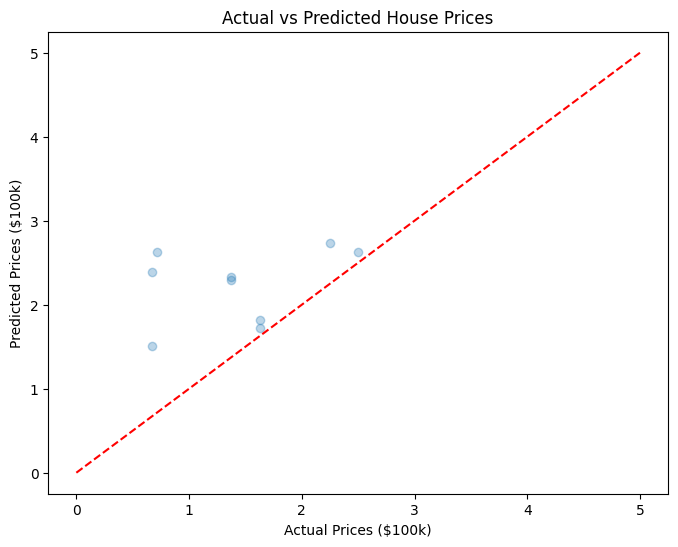

In [7]:

# %%
# 5. Evaluation
y_pred = rf_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.4f} (Hundreds of thousands of $)")
print(f"R2 Score: {r2:.4f}")

# Visualization: Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0, 5], [0, 5], '--r') # Perfect prediction line
plt.xlabel("Actual Prices ($100k)")
plt.ylabel("Predicted Prices ($100k)")
plt.title("Actual vs Predicted House Prices")
plt.show()


In [8]:

# %%
# 6. Save Model
# Note: We don't need a scaler for Random Forest, so we only save the model.
import os
if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(rf_model, 'models/housing_rf_model.pkl')
print("Model saved to 'models/housing_rf_model.pkl'")

Model saved to 'models/housing_rf_model.pkl'
